In [136]:
!pip install torchinfo
!pip install hiddenlayer
!pip install torchviz
!pip install netron
!pip install onnx onnxruntime onnxscript netron



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.1 MB/s eta 0:00:0031m18.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 15.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 7.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [199]:
import torch
import torch.nn as nn 
from torchviz import make_dot
from IPython.display import display
from graphviz import Source , Digraph
import netron

In [206]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, in1, in2, in3):
        super(Model, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Linear(in1, 1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Linear(in2, 1),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Linear(in3, 1),
            nn.ReLU()
        )

        self.final_hidden = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
            nn.Linear(5, 4),
            nn.ReLU(),
            nn.Linear(4, 3),
            nn.ReLU()
        )

        self.final = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, f1, f2, f3):
        out1 = self.branch1(f1)
        out2 = self.branch2(f2)
        out3 = self.branch3(f3)
        combined = torch.cat([out1, out2, out3], dim=1)
        x = self.final_hidden(combined)
        return self.sigmoid(self.final(x))


In [207]:
f1 = torch.rand(1,5)
f2 = torch.rand(1,5)
f3 = torch.rand(1,6)

model = Model(f1.shape[1], f2.shape[1], f3.shape[1])

# torch.onnx.export(
#     model,
#     (f1, f2, f3),
#     "model.onnx",
#     input_names=["f1","f2","f3"],
#     output_names=["output"],
#     opset_version=16
# )

# # Launch Netron
# netron.start("model.onnx")


In [208]:
model.final.bias

Parameter containing:
tensor([-0.4305], requires_grad=True)

In [209]:
model.final.weight

Parameter containing:
tensor([[-0.0849, -0.3416, -0.1094]], requires_grad=True)

In [210]:
summary(
    model,
    input_data=(
        torch.rand(10, f1.shape[1]),
        torch.rand(10, f2.shape[1]),
        torch.rand(10, f3.shape[1])
    )
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [10, 1]                   --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 1]                   6
│    └─ReLU: 2-2                         [10, 1]                   --
├─Sequential: 1-2                        [10, 1]                   --
│    └─Linear: 2-3                       [10, 1]                   6
│    └─ReLU: 2-4                         [10, 1]                   --
├─Sequential: 1-3                        [10, 1]                   --
│    └─Linear: 2-5                       [10, 1]                   7
│    └─ReLU: 2-6                         [10, 1]                   --
├─Sequential: 1-4                        [10, 3]                   --
│    └─Linear: 2-7                       [10, 5]                   20
│    └─ReLU: 2-8                         [10, 5]                   --
│    └─Linear: 2-9

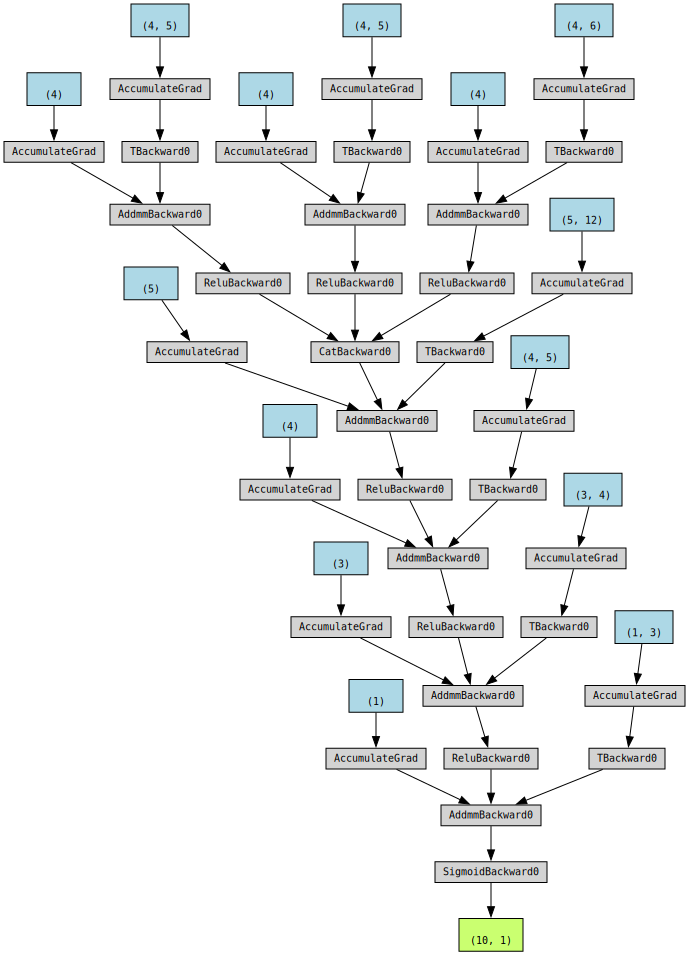

In [211]:
dot = make_dot(y, params=dict(model.named_parameters()))
display(Source(dot.source))